# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import prune
from torch.amp import autocast, GradScaler
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchvision
from torchvision.datasets import ImageNet, CIFAR10
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms._presets import ImageClassification

from pathlib import Path
from tqdm.notebook import tqdm
from einops import einsum, rearrange, reduce
from typing import Union, Tuple, Any, Generator

import copy

Automatically detect cuda if available.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Fetch the Resnet18 weights trained from the ImageNet1000 images together with the needed image preprocessing.

In [3]:
weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

The Resnet18 Architecture composed of multiple blocks where each block has residual connections.

In [4]:
model = resnet18(weights=weights)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Visualization of the different weights and biases shapes.

In [5]:
for layer_i, param in enumerate(model.parameters()):
    print('Layer', layer_i, 'shape: \n', param.shape,  '\n')

Layer 0 shape: 
 torch.Size([64, 3, 7, 7]) 

Layer 1 shape: 
 torch.Size([64]) 

Layer 2 shape: 
 torch.Size([64]) 

Layer 3 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 4 shape: 
 torch.Size([64]) 

Layer 5 shape: 
 torch.Size([64]) 

Layer 6 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 7 shape: 
 torch.Size([64]) 

Layer 8 shape: 
 torch.Size([64]) 

Layer 9 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 10 shape: 
 torch.Size([64]) 

Layer 11 shape: 
 torch.Size([64]) 

Layer 12 shape: 
 torch.Size([64, 64, 3, 3]) 

Layer 13 shape: 
 torch.Size([64]) 

Layer 14 shape: 
 torch.Size([64]) 

Layer 15 shape: 
 torch.Size([128, 64, 3, 3]) 

Layer 16 shape: 
 torch.Size([128]) 

Layer 17 shape: 
 torch.Size([128]) 

Layer 18 shape: 
 torch.Size([128, 128, 3, 3]) 

Layer 19 shape: 
 torch.Size([128]) 

Layer 20 shape: 
 torch.Size([128]) 

Layer 21 shape: 
 torch.Size([128, 64, 1, 1]) 

Layer 22 shape: 
 torch.Size([128]) 

Layer 23 shape: 
 torch.Size([128]) 

Layer 24 shape: 
 torch.Size([128

Create a dataset and dataloader object for the CIFAR10 dataset.

In [6]:
BATCH_SIZE = 512

try:
    from google.colab import drive
    drive.mount('/content/drive')
    datapath = Path().cwd() / 'drive' / 'MyDrive' / 'data'
except:
    datapath = Path().cwd() / 'data'
finally:
    print(f'Data from {datapath}')

cifar10 = CIFAR10(
    root=datapath,
    train=True,
    transform=transforms,
    download=True
)


cifar10_test = CIFAR10(
    root=datapath,
    train=False,
    transform=transforms,
    download=True
)

# cifar10 = torch.utils.data.Subset(cifar10, range(10))
# cifar10_test = torch.utils.data.Subset(cifar10_test, range(10))

dataloader = torch.utils.data.DataLoader(
    cifar10,
    batch_size=BATCH_SIZE,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    cifar10_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Data from /kaggle/working/data


100%|██████████| 170M/170M [00:03<00:00, 51.2MB/s] 


The int to string mapping of the CIFAR10 labels.

In [7]:
label_mapping = dict(enumerate(cifar10.classes))
label_mapping

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [8]:
def visualize_normalized_image(image: torch.Tensor,
                               transform: ImageClassification,
                               batch_size: int) -> None:
    """
    Combines a batch of images into 1 and plots them.
    """
    assert isinstance(image, torch.Tensor), f'image type is {type(image)}'
    assert batch_size % 2 == 0, f'uneven {batch_size}'

    image = image.numpy()
    std, mean = transform.std, transform.mean
    std, mean = np.array(std), np.array(mean)

    b1, b2 = batch_size//8, 8
    image = einsum(image, std, 'b c h w, c -> b h w c') + mean
    image = rearrange(image, '(b1 b2) h w c -> (b1 h) (b2 w) c', b1=b1, b2=b2)
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print('Shape: ', image.shape)

In [9]:
# n_of_batch_images_to_show = 4
# current_label = None

# for i, (image, label) in enumerate(dataloader):
#     label0 = int(label[0])

#     if label0 != current_label:
#         visualize_normalized_image(image, transforms, 32)
#         n_of_batch_images_to_show -= 1
#         current_label = label0

#     if n_of_batch_images_to_show == 0:
#         break


A storage object for the model loss and accuracy for both train and validation.

In [10]:
class ValTrainStorage:

    def __init__(self, name):
        self.name = name
        self.storage = {
            'train_loss': [],
            'val_loss': [],
            'train_accuracy': [],
            'val_accuracy': []
        }

    def store(self, metrics):
        assert len(metrics) == 4, f'Expecting len = 4, got {len(metrics)}'
        self.storage['train_loss'].append(metrics[0])
        self.storage['val_loss'].append(metrics[1])
        self.storage['train_accuracy'].append(metrics[2])
        self.storage['val_accuracy'].append(metrics[3])

In [11]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.

    with torch.no_grad():
        for images, labels in tqdm(dataloader_test):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    avg_loss = total_loss / len(dataloader)

    return accuracy, avg_loss


def train_model(model, dataloader, dataloader_test, device, num_epochs=10, storage=None):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)
    scaler = torch.amp.GradScaler('cuda')
    model = model.to(device)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_total_correct = 0
        train_total_samples = 0
        total_loss = 0.

        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            # optimizer.step()

            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total_samples += labels.size(0)
            train_total_correct += (predicted == labels).sum().item()


        train_accuracy = train_total_correct / train_total_samples
        train_avg_loss = total_loss / len(dataloader)
        val_accuracy, val_avg_loss = evaluate_model(model, dataloader_test, criterion, device)          
        scheduler.step()

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], learning_rate = {optimizer.param_groups[0]['lr']}",
            f'\nTrain Loss: {train_avg_loss}, Train Accuracy: {train_accuracy}',
            f'\nVal Loss: {val_avg_loss}, Val Accuracy: {val_accuracy}'
        )

        metrics = [train_avg_loss, val_avg_loss, train_accuracy, val_accuracy]
        storage.store(metrics)

A simple CNN model that will serve as the baseline for the performance of the depth pruned Resnet18.

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Convolutional feature extractor
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128 * 28 * 28, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        return x

In [13]:
model_baseline = SimpleCNN()
storage_baseline = ValTrainStorage('baseline')
train_model(model_baseline, dataloader, dataloader_test, device, num_epochs=8, storage=storage_baseline)
torch.save(model_baseline, f"model_baseline.pt")

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/8], learning_rate = 0.000965745789630079 
Train Loss: 1.729085227664636, Train Accuracy: 0.39774 
Val Loss: 1.4464138090610503, Val Accuracy: 0.486


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/8], learning_rate = 0.0008681980515339464 
Train Loss: 1.3302391122798531, Train Accuracy: 0.5276 
Val Loss: 1.2785429537296296, Val Accuracy: 0.5458


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/8], learning_rate = 0.0007222075445642906 
Train Loss: 1.1847915065531829, Train Accuracy: 0.58428 
Val Loss: 1.2005702316761018, Val Accuracy: 0.5735


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/8], learning_rate = 0.00055 
Train Loss: 1.0995605308182386, Train Accuracy: 0.61666 
Val Loss: 1.157865160703659, Val Accuracy: 0.5911


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/8], learning_rate = 0.00037779245543570966 
Train Loss: 1.0246484820940056, Train Accuracy: 0.64434 
Val Loss: 1.1315658032894134, Val Accuracy: 0.5993


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/8], learning_rate = 0.00023180194846605365 
Train Loss: 0.9616797092009564, Train Accuracy: 0.66796 
Val Loss: 1.1293590724468232, Val Accuracy: 0.6053


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/8], learning_rate = 0.00013425421036992097 
Train Loss: 0.9120757993386717, Train Accuracy: 0.68558 
Val Loss: 1.0895222812891006, Val Accuracy: 0.617


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/8], learning_rate = 0.0001 
Train Loss: 0.8714580517642352, Train Accuracy: 0.70138 
Val Loss: 1.081231728196144, Val Accuracy: 0.625


In [14]:
total_params = sum(p.numel() for p in model_baseline.parameters())
trainable_params = sum(p.numel() for p in model_baseline.parameters() if p.requires_grad)
print('Total Parameters: ', total_params)
print('Trainable Parameters: ', trainable_params)

Total Parameters:  1096778
Trainable Parameters:  1096778


Iteratively pruning the resnet18 model block by block. Starting from changing the head or the 1st fully-connected layer to match the CIFAR10 dataset, then continue replacing each block with a sequential AdaptiveAvgPool2d, Flatten, and Linear layer until all the blocks with residual connections are removed. Note that only the head is trainable -- all other parameters are frozen as they are believed to already be trained to detect the features.

In [15]:
N_EPOCHS = 8
fc_out = len(label_mapping)
total_params_list = []
trainable_params_list = []
storage_list = []

layers = [
    'layer1.0',
    'layer1.1',
    'layer2.0',
    'layer2.1',
    'layer3.0',
    'layer3.1',
    'layer4.0',
    'layer4.1',
]

model_fc_in = model.fc.in_features
model_fc_out = len(label_mapping)
model.fc = nn.Linear(model_fc_in, model_fc_out)

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
    
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params_list.append(total_params)
trainable_params_list.append(trainable_params)

storage = ValTrainStorage('head')
train_model(model, 
            dataloader, 
            dataloader_test,
            device,
            num_epochs=N_EPOCHS, 
            storage=storage)
storage_list.append(storage)
torch.save(model, 
           f"model_replaced_head.pt")

for i in range(len(layers), 0, -1):
    model_copy = copy.deepcopy(model)
    model_copy.avgpool = nn.Identity()
    model_copy.fc = nn.Identity()
    layers_to_prune = layers[i-1:]
    print()

    for j, layer in enumerate(layers_to_prune):
    
        if j == 0:
            non_identity_layer = layer
            new_layer = nn.Sequential(
                nn.AdaptiveAvgPool2d(
                    output_size=(1, 1)
                ),
                nn.Flatten()
            )
        else:
            new_layer = nn.Identity()
            
        print(f'Pruned {layer}')
        model_copy.set_submodule(layer, new_layer)

    fc_in = model_copy(torch.randn(1, 3, 224, 224).to(device)).shape[1]
    (model_copy
     .get_submodule(non_identity_layer)
     .append(nn.Linear(fc_in, fc_out)))

    for name, p in model_copy.named_parameters():
        if non_identity_layer in name:
            p.requires_grad = True
        else:
            p.requires_grad = False


    total_params = sum(p.numel() for p in model_copy.parameters())
    trainable_params = sum(p.numel() for p in model_copy.parameters() if p.requires_grad)
    total_params_list.append(total_params)
    trainable_params_list.append(trainable_params)

    storage = ValTrainStorage(non_identity_layer)
    train_model(model_copy, 
                dataloader, 
                dataloader_test,
                device,
                num_epochs=N_EPOCHS, 
                storage=storage)
    storage_list.append(storage)
    torch.save(model_copy, f"model_replaced_{non_identity_layer}.pt")
    

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/8], learning_rate = 0.000965745789630079 
Train Loss: 1.306133000826349, Train Accuracy: 0.59484 
Val Loss: 0.9069855451583863, Val Accuracy: 0.717


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/8], learning_rate = 0.0008681980515339464 
Train Loss: 0.8131837838766526, Train Accuracy: 0.73968 
Val Loss: 0.7687858700752258, Val Accuracy: 0.7484


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/8], learning_rate = 0.0007222075445642906 
Train Loss: 0.729790985584259, Train Accuracy: 0.75824 
Val Loss: 0.7216124981641769, Val Accuracy: 0.7613


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/8], learning_rate = 0.00055 
Train Loss: 0.6924169763010375, Train Accuracy: 0.7676 
Val Loss: 0.6998428761959076, Val Accuracy: 0.767


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/8], learning_rate = 0.00037779245543570966 
Train Loss: 0.6722150238192811, Train Accuracy: 0.77334 
Val Loss: 0.6855421781539917, Val Accuracy: 0.7655


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/8], learning_rate = 0.00023180194846605365 
Train Loss: 0.6579352909204911, Train Accuracy: 0.77714 
Val Loss: 0.6767354369163513, Val Accuracy: 0.7717


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/8], learning_rate = 0.00013425421036992097 
Train Loss: 0.6502078291104765, Train Accuracy: 0.77884 
Val Loss: 0.6711940318346024, Val Accuracy: 0.7738


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/8], learning_rate = 0.0001 
Train Loss: 0.6471890052970575, Train Accuracy: 0.7802 
Val Loss: 0.6679986238479614, Val Accuracy: 0.7742

Pruned layer4.1


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/8], learning_rate = 0.000965745789630079 
Train Loss: 2.0722002995257474, Train Accuracy: 0.4945 
Val Loss: 1.8686923682689667, Val Accuracy: 0.6117


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/8], learning_rate = 0.0008681980515339464 
Train Loss: 1.7324598115317675, Train Accuracy: 0.6217 
Val Loss: 1.6094529151916503, Val Accuracy: 0.6309


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/8], learning_rate = 0.0007222075445642906 
Train Loss: 1.5287690065344985, Train Accuracy: 0.63798 
Val Loss: 1.4539072513580322, Val Accuracy: 0.6392


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/8], learning_rate = 0.00055 
Train Loss: 1.4048755083765303, Train Accuracy: 0.64822 
Val Loss: 1.358055454492569, Val Accuracy: 0.6464


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/8], learning_rate = 0.00037779245543570966 
Train Loss: 1.3280974164301036, Train Accuracy: 0.65588 
Val Loss: 1.2996612966060639, Val Accuracy: 0.6541


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/8], learning_rate = 0.00023180194846605365 
Train Loss: 1.2809199678654573, Train Accuracy: 0.66064 
Val Loss: 1.2631908655166626, Val Accuracy: 0.6563


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/8], learning_rate = 0.00013425421036992097 
Train Loss: 1.2523868156939137, Train Accuracy: 0.66426 
Val Loss: 1.2436975121498108, Val Accuracy: 0.6601


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/8], learning_rate = 0.0001 
Train Loss: 1.2365806589321213, Train Accuracy: 0.66704 
Val Loss: 1.2330892562866211, Val Accuracy: 0.6619

Pruned layer4.0
Pruned layer4.1


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/8], learning_rate = 0.000965745789630079 
Train Loss: 2.2007535939313927, Train Accuracy: 0.3692 
Val Loss: 2.103054678440094, Val Accuracy: 0.4704


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/8], learning_rate = 0.0008681980515339464 
Train Loss: 2.0273627821280034, Train Accuracy: 0.49954 
Val Loss: 1.954094135761261, Val Accuracy: 0.5157


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/8], learning_rate = 0.0007222075445642906 
Train Loss: 1.9003864052344341, Train Accuracy: 0.53408 
Val Loss: 1.845976287126541, Val Accuracy: 0.5437


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/8], learning_rate = 0.00055 
Train Loss: 1.8105353007511216, Train Accuracy: 0.54448 
Val Loss: 1.7721778213977815, Val Accuracy: 0.5567


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/8], learning_rate = 0.00037779245543570966 
Train Loss: 1.748559597803622, Train Accuracy: 0.55986 
Val Loss: 1.722234046459198, Val Accuracy: 0.5588


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/8], learning_rate = 0.00023180194846605365 
Train Loss: 1.707770356110164, Train Accuracy: 0.56404 
Val Loss: 1.6911267399787904, Val Accuracy: 0.563


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/8], learning_rate = 0.00013425421036992097 
Train Loss: 1.6836248891694205, Train Accuracy: 0.5656 
Val Loss: 1.6726904034614563, Val Accuracy: 0.5633


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/8], learning_rate = 0.0001 
Train Loss: 1.669071810586112, Train Accuracy: 0.56622 
Val Loss: 1.6622638523578643, Val Accuracy: 0.5676

Pruned layer3.1
Pruned layer4.0
Pruned layer4.1


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/8], learning_rate = 0.000965745789630079 
Train Loss: 2.175783799619091, Train Accuracy: 0.3505 
Val Loss: 2.059469497203827, Val Accuracy: 0.4482


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/8], learning_rate = 0.0008681980515339464 
Train Loss: 1.9782263952858594, Train Accuracy: 0.4621 
Val Loss: 1.8996801853179932, Val Accuracy: 0.4823


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/8], learning_rate = 0.0007222075445642906 
Train Loss: 1.8486501744815282, Train Accuracy: 0.49542 
Val Loss: 1.7950508832931518, Val Accuracy: 0.5007


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/8], learning_rate = 0.00055 
Train Loss: 1.7631418559016014, Train Accuracy: 0.505 
Val Loss: 1.7274499595165254, Val Accuracy: 0.5102


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/8], learning_rate = 0.00037779245543570966 
Train Loss: 1.7072983140848121, Train Accuracy: 0.51572 
Val Loss: 1.6826165735721588, Val Accuracy: 0.5162


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/8], learning_rate = 0.00023180194846605365 
Train Loss: 1.6712993213108607, Train Accuracy: 0.5199 
Val Loss: 1.6558012306690215, Val Accuracy: 0.5204


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/8], learning_rate = 0.00013425421036992097 
Train Loss: 1.6500976389768172, Train Accuracy: 0.52458 
Val Loss: 1.63952397108078, Val Accuracy: 0.5224


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/8], learning_rate = 0.0001 
Train Loss: 1.63763670653713, Train Accuracy: 0.52622 
Val Loss: 1.63095463514328, Val Accuracy: 0.525

Pruned layer3.0
Pruned layer3.1
Pruned layer4.0
Pruned layer4.1


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/8], learning_rate = 0.000965745789630079 
Train Loss: 2.254127093723842, Train Accuracy: 0.23534 
Val Loss: 2.2016736268997192, Val Accuracy: 0.2739


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/8], learning_rate = 0.0008681980515339464 
Train Loss: 2.159490410162478, Train Accuracy: 0.34366 
Val Loss: 2.116221213340759, Val Accuracy: 0.3709


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/8], learning_rate = 0.0007222075445642906 
Train Loss: 2.085374056076517, Train Accuracy: 0.38474 
Val Loss: 2.050858795642853, Val Accuracy: 0.424


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/8], learning_rate = 0.00055 
Train Loss: 2.030248834162342, Train Accuracy: 0.41388 
Val Loss: 2.0045106291770933, Val Accuracy: 0.4115


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/8], learning_rate = 0.00037779245543570966 
Train Loss: 1.9911365703660615, Train Accuracy: 0.42654 
Val Loss: 1.9725332260131836, Val Accuracy: 0.4192


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/8], learning_rate = 0.00023180194846605365 
Train Loss: 1.9650145379864439, Train Accuracy: 0.42466 
Val Loss: 1.95240758061409, Val Accuracy: 0.4327


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/8], learning_rate = 0.00013425421036992097 
Train Loss: 1.9487386625640246, Train Accuracy: 0.43964 
Val Loss: 1.9400577306747437, Val Accuracy: 0.432


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/8], learning_rate = 0.0001 
Train Loss: 1.9392142916212276, Train Accuracy: 0.43582 
Val Loss: 1.932551246881485, Val Accuracy: 0.437

Pruned layer2.1
Pruned layer3.0
Pruned layer3.1
Pruned layer4.0
Pruned layer4.1


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/8], learning_rate = 0.000965745789630079 
Train Loss: 2.2328068893782946, Train Accuracy: 0.24874 
Val Loss: 2.1661797404289245, Val Accuracy: 0.3218


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/8], learning_rate = 0.0008681980515339464 
Train Loss: 2.1177492993218556, Train Accuracy: 0.34724 
Val Loss: 2.0679118275642394, Val Accuracy: 0.3824


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/8], learning_rate = 0.0007222075445642906 
Train Loss: 2.035155254967359, Train Accuracy: 0.3799 
Val Loss: 1.9992288887500762, Val Accuracy: 0.3777


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/8], learning_rate = 0.00055 
Train Loss: 1.977490549184838, Train Accuracy: 0.3958 
Val Loss: 1.9512904822826385, Val Accuracy: 0.3858


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/8], learning_rate = 0.00037779245543570966 
Train Loss: 1.9388136146019916, Train Accuracy: 0.40294 
Val Loss: 1.9198807895183563, Val Accuracy: 0.3976


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/8], learning_rate = 0.00023180194846605365 
Train Loss: 1.913273739571474, Train Accuracy: 0.40654 
Val Loss: 1.8993758857250214, Val Accuracy: 0.4089


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/8], learning_rate = 0.00013425421036992097 
Train Loss: 1.8975827414162305, Train Accuracy: 0.41462 
Val Loss: 1.887971144914627, Val Accuracy: 0.4101


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/8], learning_rate = 0.0001 
Train Loss: 1.8885265126520274, Train Accuracy: 0.41282 
Val Loss: 1.8819755554199218, Val Accuracy: 0.412

Pruned layer2.0
Pruned layer2.1
Pruned layer3.0
Pruned layer3.1
Pruned layer4.0
Pruned layer4.1


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/8], learning_rate = 0.000965745789630079 
Train Loss: 2.283885140808261, Train Accuracy: 0.16344 
Val Loss: 2.251258409023285, Val Accuracy: 0.1957


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/8], learning_rate = 0.0008681980515339464 
Train Loss: 2.2256922770519645, Train Accuracy: 0.25038 
Val Loss: 2.1985812187194824, Val Accuracy: 0.2729


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/8], learning_rate = 0.0007222075445642906 
Train Loss: 2.179332000868661, Train Accuracy: 0.27656 
Val Loss: 2.156508505344391, Val Accuracy: 0.3121


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/8], learning_rate = 0.00055 
Train Loss: 2.1437493903296336, Train Accuracy: 0.2989 
Val Loss: 2.1259364008903505, Val Accuracy: 0.3155


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/8], learning_rate = 0.00037779245543570966 
Train Loss: 2.117958297534865, Train Accuracy: 0.30884 
Val Loss: 2.1048513054847717, Val Accuracy: 0.3307


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/8], learning_rate = 0.00023180194846605365 
Train Loss: 2.1006127230975093, Train Accuracy: 0.3183 
Val Loss: 2.091395652294159, Val Accuracy: 0.3187


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/8], learning_rate = 0.00013425421036992097 
Train Loss: 2.089590009377927, Train Accuracy: 0.32394 
Val Loss: 2.082031083106995, Val Accuracy: 0.3331


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/8], learning_rate = 0.0001 
Train Loss: 2.0831988587671395, Train Accuracy: 0.32656 
Val Loss: 2.07858167886734, Val Accuracy: 0.3387

Pruned layer1.1
Pruned layer2.0
Pruned layer2.1
Pruned layer3.0
Pruned layer3.1
Pruned layer4.0
Pruned layer4.1


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/8], learning_rate = 0.000965745789630079 
Train Loss: 2.278647330342507, Train Accuracy: 0.16194 
Val Loss: 2.233866822719574, Val Accuracy: 0.2299


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/8], learning_rate = 0.0008681980515339464 
Train Loss: 2.20303543976375, Train Accuracy: 0.24366 
Val Loss: 2.1690452456474305, Val Accuracy: 0.2534


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/8], learning_rate = 0.0007222075445642906 
Train Loss: 2.149004286649276, Train Accuracy: 0.26962 
Val Loss: 2.122914469242096, Val Accuracy: 0.2808


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/8], learning_rate = 0.00055 
Train Loss: 2.1114624519737397, Train Accuracy: 0.28636 
Val Loss: 2.091036820411682, Val Accuracy: 0.2993


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/8], learning_rate = 0.00037779245543570966 
Train Loss: 2.0857541926053105, Train Accuracy: 0.29182 
Val Loss: 2.0700864672660826, Val Accuracy: 0.3041


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/8], learning_rate = 0.00023180194846605365 
Train Loss: 2.069446298540855, Train Accuracy: 0.29796 
Val Loss: 2.0576630234718323, Val Accuracy: 0.3039


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/8], learning_rate = 0.00013425421036992097 
Train Loss: 2.059569794304517, Train Accuracy: 0.29838 
Val Loss: 2.050527262687683, Val Accuracy: 0.3074


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/8], learning_rate = 0.0001 
Train Loss: 2.0534504627694887, Train Accuracy: 0.30252 
Val Loss: 2.046043074131012, Val Accuracy: 0.3071

Pruned layer1.0
Pruned layer1.1
Pruned layer2.0
Pruned layer2.1
Pruned layer3.0
Pruned layer3.1
Pruned layer4.0
Pruned layer4.1


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/8], learning_rate = 0.000965745789630079 
Train Loss: 2.2608394647131163, Train Accuracy: 0.17744 
Val Loss: 2.2206831693649294, Val Accuracy: 0.2177


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/8], learning_rate = 0.0008681980515339464 
Train Loss: 2.198595219728898, Train Accuracy: 0.22064 
Val Loss: 2.1698009252548216, Val Accuracy: 0.2339


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/8], learning_rate = 0.0007222075445642906 
Train Loss: 2.159213431027471, Train Accuracy: 0.22954 
Val Loss: 2.136822211742401, Val Accuracy: 0.2405


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/8], learning_rate = 0.00055 
Train Loss: 2.133524228115471, Train Accuracy: 0.23622 
Val Loss: 2.1156086683273316, Val Accuracy: 0.2463


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/8], learning_rate = 0.00037779245543570966 
Train Loss: 2.1169683203405265, Train Accuracy: 0.23954 
Val Loss: 2.101386022567749, Val Accuracy: 0.2488


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/8], learning_rate = 0.00023180194846605365 
Train Loss: 2.1059240637993324, Train Accuracy: 0.24534 
Val Loss: 2.0932299971580504, Val Accuracy: 0.2514


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/8], learning_rate = 0.00013425421036992097 
Train Loss: 2.0994572225882084, Train Accuracy: 0.24538 
Val Loss: 2.088331127166748, Val Accuracy: 0.2525


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/8], learning_rate = 0.0001 
Train Loss: 2.095722492860288, Train Accuracy: 0.24662 
Val Loss: 2.0856738328933715, Val Accuracy: 0.2531


[11181642, 6461002, 2785354, 1604682, 684362, 388938, 158154, 84170, 10186]


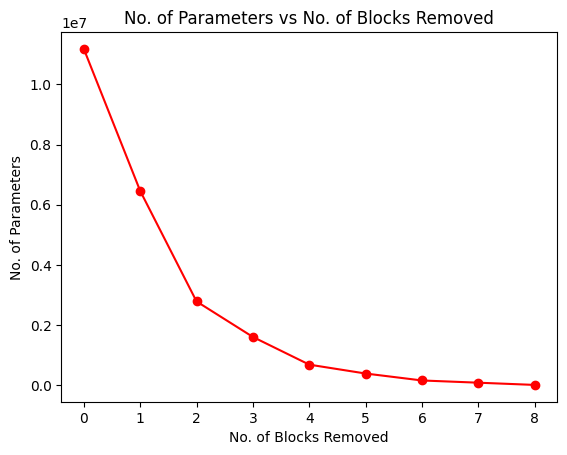

In [16]:
print(total_params_list)
plt.plot(total_params_list, 'r-o')
plt.xlabel('No. of Blocks Removed')
plt.ylabel('No. of Parameters')
plt.title('No. of Parameters vs No. of Blocks Removed')
plt.show();

[5130, 5130, 2570, 2570, 1290, 1290, 650, 650, 650]


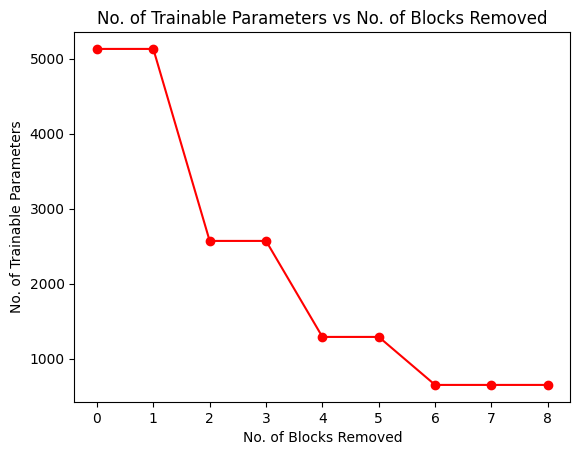

In [17]:
print(trainable_params_list)
plt.plot(trainable_params_list, 'r-o')
plt.xlabel('No. of Blocks Removed')
plt.ylabel('No. of Trainable Parameters')
plt.title('No. of Trainable Parameters vs No. of Blocks Removed')
plt.show();

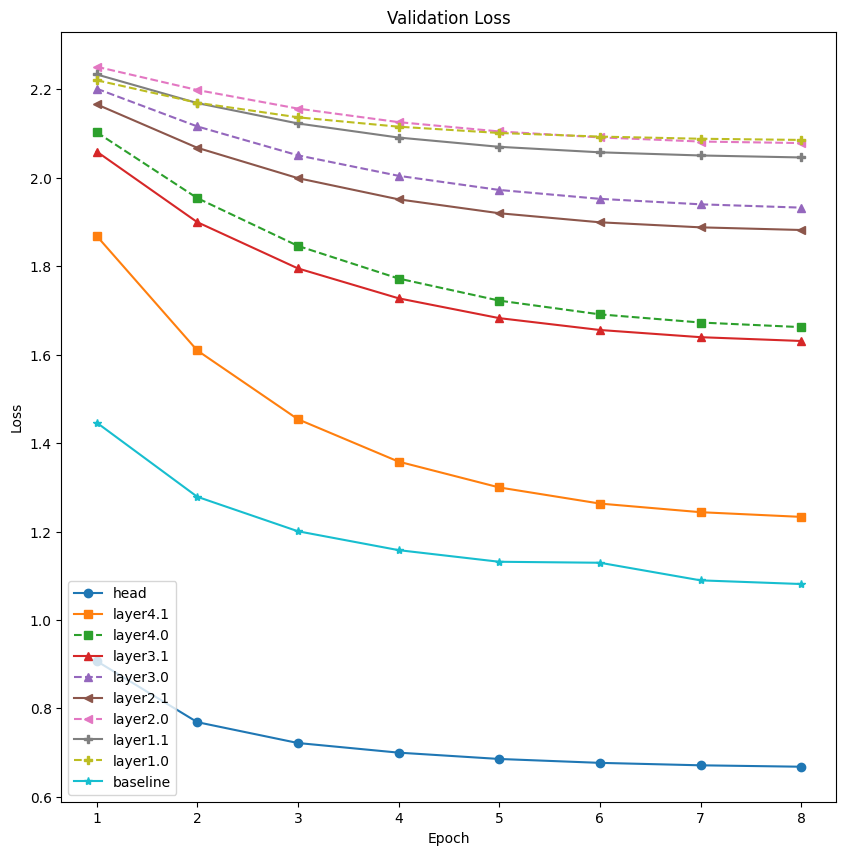

In [18]:
x = np.arange(1, N_EPOCHS+1, 1)
plt.figure(figsize=(10, 10))
markers = [
    "o-",
    "s-",
    "s--",
    "^-",
    "^--",
    "<-",
    "<--",
    "P-",
    "P--",
]
for s, m in zip(storage_list, markers):

    plt.plot(x, s.storage['val_loss'], m , label=s.name)

plt.plot(x, storage_baseline.storage['val_loss'], '*-', label=storage_baseline.name)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show()

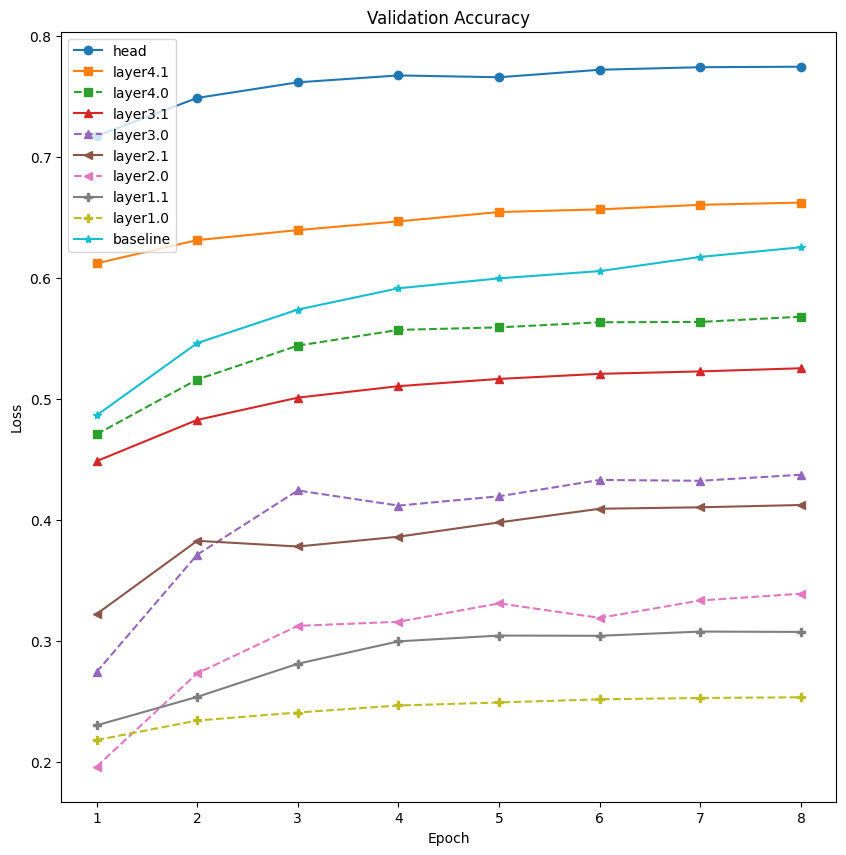

In [19]:
x = np.arange(1, N_EPOCHS+1, 1)
plt.figure(figsize=(10, 10)) 
markers = [
    "o-",
    "s-",
    "s--",
    "^-",
    "^--",
    "<-",
    "<--",
    "P-",
    "P--",
]
for s, m in zip(storage_list, markers):

    plt.plot(x, s.storage['val_accuracy'], m, label=s.name)

plt.plot(x, storage_baseline.storage['val_accuracy'], '*-', label=storage_baseline.name)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Accuracy')
plt.show()

In [20]:
dfs = []
for s in storage_list:
    df = pd.DataFrame(s.storage)
    df['name'] = s.name
    df = df.iloc[len(df)-1:]
    dfs.append(df)

perf_df = pd.concat(dfs).reset_index(drop=True)
perf_df

,train_loss,val_loss,train_accuracy,val_accuracy,name
0,0.647189,0.667999,0.78020,0.7742,head
1,1.236581,1.233089,0.66704,0.6619,layer4.1
2,1.669072,1.662264,0.56622,0.5676,layer4.0
3,1.637637,1.630955,0.52622,0.5250,layer3.1
4,1.939214,1.932551,0.43582,0.4370,layer3.0
5,1.888527,1.881976,0.41282,0.4120,layer2.1
6,2.083199,2.078582,0.32656,0.3387,layer2.0
7,2.053450,2.046043,0.30252,0.3071,layer1.1
8,2.095722,2.085674,0.24662,0.2531,layer1.0


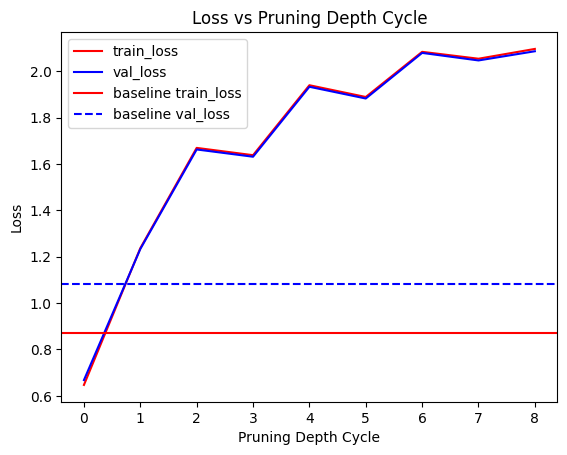

In [21]:
plt.plot(perf_df['train_loss'], 'r', label='train_loss')
plt.plot(perf_df['val_loss'], 'b', label='val_loss')
plt.axhline(y=storage_baseline.storage['train_loss'][-1], color='r', linestyle='-', label='baseline train_loss')
plt.axhline(y=storage_baseline.storage['val_loss'][-1], color='b', linestyle='--', label='baseline val_loss')

plt.xlabel('Pruning Depth Cycle')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Pruning Depth Cycle')
plt.show()


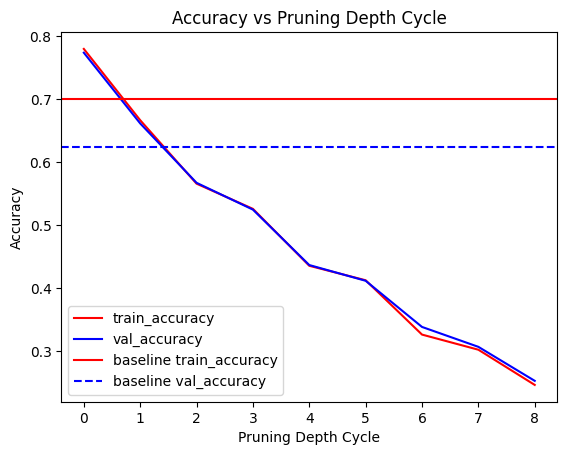

In [22]:
plt.plot(perf_df['train_accuracy'], 'r', label='train_accuracy')
plt.plot(perf_df['val_accuracy'], 'b', label='val_accuracy')
plt.axhline(y=storage_baseline.storage['train_accuracy'][-1], color='r', linestyle='-', label='baseline train_accuracy')
plt.axhline(y=storage_baseline.storage['val_accuracy'][-1], color='b', linestyle='--', label='baseline val_accuracy')

plt.xlabel('Pruning Depth Cycle')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Pruning Depth Cycle')
plt.show()

In [23]:
import os, sys
sys.exit()

SystemExit: 

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
